In [ ]:
!nvidia-smi

## 1) Installing libraries

In [1]:
# !pip install transformers
# !pip install datasets
# !pip install wandb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [3]:
# enter your personal read token

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/TRAC_plus_scrapped", use_auth_token=True)

print(aggression_dataset)

Using custom data configuration IIIT-L--TRAC_plus_scrapped-e37030efaeb75f40
Reusing dataset csv (/home/diptesh/.cache/huggingface/datasets/IIIT-L___csv/IIIT-L--TRAC_plus_scrapped-e37030efaeb75f40/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 11390
    })
    test: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1424
    })
    validation: Dataset({
        features: ['Sentence', 'Label'],
        num_rows: 1424
    })
})


In [6]:
train_ds = aggression_dataset['train']
train_ds

Dataset({
    features: ['Sentence', 'Label'],
    num_rows: 11390
})

## 3) Converting to dataframe

In [7]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

,Sentence,Label
0,I am also lesbian,0
1,I think we should first gather the interested ...,0
2,It should be applicable to every relegion.,1
3,People in Tamilnadu have some sort of inferior...,1
4,where he gone,1


In [8]:
test_df = aggression_dataset['test'][:]

In [9]:
train_df['Label'].value_counts()

0    5144
1    3685
2    2561
Name: Label, dtype: int64

In [10]:
# 11390
# NAG-CAG-OAG (0-1-2) = 0.45-0.32-0.23

Seeing Distribution

In [11]:
disb_df = train_df.copy(deep=True)

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


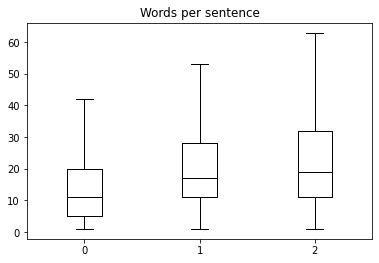

In [12]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [13]:
from transformers import AutoTokenizer

In [14]:
model_ckpt = 'ai4bharat/indic-bert'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
tokenizer.vocab_size

200000

In [16]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [17]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=510)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=510)

In [19]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [21]:
import torch

In [22]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [23]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [25]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: diptesh. Use `wandb login --relogin` to force relogin


True

In [26]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [27]:
from transformers import Trainer, TrainingArguments

In [28]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-combined-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=20,
                                  learning_rate=1e-06,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.001,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="albert-combined-DS",
                                  push_to_hub=True)

In [29]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [30]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    # device = torch.device('cuda')
    # inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.21, 0.33, 0.46]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [31]:
from transformers import EarlyStoppingCallback

In [32]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

In [33]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        # callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/ai4bharat/indic-bert/resolve/main/config.json from cache at /home/diptesh/.cache/huggingface/transformers/2d290a1a22a5f80e173def8b2f31f12d68a957542e6769ab06bfc3de06bc49f4.06ba3893e888d6ff1388c45cdbee1fb785542ae22b70ff159f55da323230a159
Model config AlbertConfig {
  "_name_or_path": "ai4bharat/indic-bert",
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hi

  0%|          | 0/14240 [00:00<?, ?it/s]

/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 1.0904, 'learning_rate': 9.50070224719101e-07, 'epoch': 1.0}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-711
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-711/config.json


{'eval_loss': 1.075875163078308, 'eval_accuracy': 0.4452247191011236, 'eval_precision': 0.43683083860360244, 'eval_recall': 0.41550123520140386, 'eval_f1': 0.33334441300710127, 'eval_runtime': 5.3548, 'eval_samples_per_second': 265.929, 'eval_steps_per_second': 8.404, 'epoch': 1.0}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-711/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-711/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-711/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 1.0537, 'learning_rate': 9.001404494382022e-07, 'epoch': 2.0}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-1422
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-1422/config.json


{'eval_loss': 1.036274790763855, 'eval_accuracy': 0.5063202247191011, 'eval_precision': 0.5078763056940208, 'eval_recall': 0.4902487128213436, 'eval_f1': 0.48889713319484995, 'eval_runtime': 5.1582, 'eval_samples_per_second': 276.064, 'eval_steps_per_second': 8.724, 'epoch': 2.0}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-1422/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-1422/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-1422/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 1.0233, 'learning_rate': 8.502106741573033e-07, 'epoch': 3.0}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2133
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2133/config.json


{'eval_loss': 1.0207017660140991, 'eval_accuracy': 0.5301966292134831, 'eval_precision': 0.5195278592074146, 'eval_recall': 0.5266104680396245, 'eval_f1': 0.49562824295689917, 'eval_runtime': 5.1594, 'eval_samples_per_second': 276.003, 'eval_steps_per_second': 8.722, 'epoch': 3.0}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2133/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2133/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2133/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 1.0091, 'learning_rate': 8.002808988764045e-07, 'epoch': 3.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2844
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2844/config.json


{'eval_loss': 1.0168235301971436, 'eval_accuracy': 0.5379213483146067, 'eval_precision': 0.5247759594875997, 'eval_recall': 0.5313183643058778, 'eval_f1': 0.5123943288142935, 'eval_runtime': 5.4675, 'eval_samples_per_second': 260.45, 'eval_steps_per_second': 8.231, 'epoch': 3.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2844/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2844/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-2844/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9983, 'learning_rate': 7.503511235955056e-07, 'epoch': 4.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-3555
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-3555/config.json


{'eval_loss': 1.0008814334869385, 'eval_accuracy': 0.5681179775280899, 'eval_precision': 0.5344009047246397, 'eval_recall': 0.5424387649685184, 'eval_f1': 0.5334876435409874, 'eval_runtime': 5.2772, 'eval_samples_per_second': 269.842, 'eval_steps_per_second': 8.527, 'epoch': 4.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-3555/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-3555/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-3555/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9854, 'learning_rate': 7.004213483146067e-07, 'epoch': 5.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4266
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4266/config.json


{'eval_loss': 0.9949767589569092, 'eval_accuracy': 0.5828651685393258, 'eval_precision': 0.5489801089926324, 'eval_recall': 0.5548498305025479, 'eval_f1': 0.549169325558443, 'eval_runtime': 5.2865, 'eval_samples_per_second': 269.367, 'eval_steps_per_second': 8.512, 'epoch': 5.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4266/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4266/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4266/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9728, 'learning_rate': 6.504915730337079e-07, 'epoch': 6.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4977
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4977/config.json


{'eval_loss': 0.9917328357696533, 'eval_accuracy': 0.5751404494382022, 'eval_precision': 0.5435846271904704, 'eval_recall': 0.5514514309876549, 'eval_f1': 0.5434264770663108, 'eval_runtime': 5.3164, 'eval_samples_per_second': 267.85, 'eval_steps_per_second': 8.464, 'epoch': 6.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4977/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4977/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-4977/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9616, 'learning_rate': 6.005617977528089e-07, 'epoch': 7.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-5688
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-5688/config.json


{'eval_loss': 0.9888074398040771, 'eval_accuracy': 0.5491573033707865, 'eval_precision': 0.5182594272771927, 'eval_recall': 0.5307991008444364, 'eval_f1': 0.5107389316644303, 'eval_runtime': 5.2903, 'eval_samples_per_second': 269.171, 'eval_steps_per_second': 8.506, 'epoch': 7.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-5688/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-5688/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-5688/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9476, 'learning_rate': 5.506320224719101e-07, 'epoch': 8.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-6399
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-6399/config.json


{'eval_loss': 0.9815396070480347, 'eval_accuracy': 0.5835674157303371, 'eval_precision': 0.5487920584435342, 'eval_recall': 0.552642863366987, 'eval_f1': 0.5499080936065693, 'eval_runtime': 5.2817, 'eval_samples_per_second': 269.612, 'eval_steps_per_second': 8.52, 'epoch': 8.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-6399/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-6399/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-6399/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9355, 'learning_rate': 5.007022471910111e-07, 'epoch': 9.99}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7110
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7110/config.json


{'eval_loss': 0.9961762428283691, 'eval_accuracy': 0.5519662921348315, 'eval_precision': 0.5316268079864302, 'eval_recall': 0.5418926650248806, 'eval_f1': 0.5223142694161299, 'eval_runtime': 5.3208, 'eval_samples_per_second': 267.627, 'eval_steps_per_second': 8.457, 'epoch': 9.99}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7110/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7110/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7110/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.924, 'learning_rate': 4.5077247191011236e-07, 'epoch': 10.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7821
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7821/config.json


{'eval_loss': 0.9822890758514404, 'eval_accuracy': 0.5674157303370787, 'eval_precision': 0.5362780429211627, 'eval_recall': 0.5452732999400989, 'eval_f1': 0.5315292190760047, 'eval_runtime': 5.3027, 'eval_samples_per_second': 268.54, 'eval_steps_per_second': 8.486, 'epoch': 10.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7821/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7821/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-7821/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9112, 'learning_rate': 4.008426966292134e-07, 'epoch': 11.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-8532
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-8532/config.json


{'eval_loss': 0.9773027300834656, 'eval_accuracy': 0.5828651685393258, 'eval_precision': 0.5478774365730886, 'eval_recall': 0.5504479909045249, 'eval_f1': 0.5487726300887417, 'eval_runtime': 5.2769, 'eval_samples_per_second': 269.854, 'eval_steps_per_second': 8.528, 'epoch': 11.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-8532/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-8532/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-8532/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.9002, 'learning_rate': 3.509129213483146e-07, 'epoch': 12.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9243
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9243/config.json


{'eval_loss': 0.9761456847190857, 'eval_accuracy': 0.5814606741573034, 'eval_precision': 0.5451801757736446, 'eval_recall': 0.5478599941706835, 'eval_f1': 0.5459388353409992, 'eval_runtime': 5.3526, 'eval_samples_per_second': 266.039, 'eval_steps_per_second': 8.407, 'epoch': 12.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9243/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9243/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9243/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8904, 'learning_rate': 3.009831460674157e-07, 'epoch': 13.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9954
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9954/config.json


{'eval_loss': 0.9726341962814331, 'eval_accuracy': 0.5912921348314607, 'eval_precision': 0.5557564619272425, 'eval_recall': 0.5494518006036734, 'eval_f1': 0.5512455919601237, 'eval_runtime': 5.3024, 'eval_samples_per_second': 268.559, 'eval_steps_per_second': 8.487, 'epoch': 13.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9954/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9954/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-9954/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8823, 'learning_rate': 2.5105337078651685e-07, 'epoch': 14.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-10665
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-10665/config.json


{'eval_loss': 0.9785109758377075, 'eval_accuracy': 0.5842696629213483, 'eval_precision': 0.5525718890028101, 'eval_recall': 0.5582627646899021, 'eval_f1': 0.5533422732311472, 'eval_runtime': 5.2699, 'eval_samples_per_second': 270.211, 'eval_steps_per_second': 8.539, 'epoch': 14.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-10665/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-10665/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-10665/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8742, 'learning_rate': 2.0112359550561798e-07, 'epoch': 15.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-11376
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-11376/config.json


{'eval_loss': 0.9764564037322998, 'eval_accuracy': 0.5842696629213483, 'eval_precision': 0.5492622197030482, 'eval_recall': 0.5543177175480611, 'eval_f1': 0.5500485089958774, 'eval_runtime': 5.309, 'eval_samples_per_second': 268.223, 'eval_steps_per_second': 8.476, 'epoch': 15.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-11376/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-11376/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-11376/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8653, 'learning_rate': 1.511938202247191e-07, 'epoch': 16.98}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12087
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12087/config.json


{'eval_loss': 0.9746454358100891, 'eval_accuracy': 0.586376404494382, 'eval_precision': 0.5500923358547104, 'eval_recall': 0.5531564217939479, 'eval_f1': 0.550783932074772, 'eval_runtime': 5.2849, 'eval_samples_per_second': 269.446, 'eval_steps_per_second': 8.515, 'epoch': 16.98}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12087/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12087/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12087/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8612, 'learning_rate': 1.0126404494382023e-07, 'epoch': 17.97}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12798
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12798/config.json


{'eval_loss': 0.977009117603302, 'eval_accuracy': 0.5884831460674157, 'eval_precision': 0.553878720161095, 'eval_recall': 0.5565677410176953, 'eval_f1': 0.554795800793546, 'eval_runtime': 5.2866, 'eval_samples_per_second': 269.362, 'eval_steps_per_second': 8.512, 'epoch': 17.97}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12798/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12798/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12798/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8558, 'learning_rate': 5.133426966292135e-08, 'epoch': 18.97}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-13509
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-13509/config.json


{'eval_loss': 0.9795736074447632, 'eval_accuracy': 0.5835674157303371, 'eval_precision': 0.5509644948816583, 'eval_recall': 0.5564980904459665, 'eval_f1': 0.5519992206686378, 'eval_runtime': 5.2897, 'eval_samples_per_second': 269.2, 'eval_steps_per_second': 8.507, 'epoch': 18.97}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-13509/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-13509/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-13509/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1424
  Batch size = 32


{'loss': 0.8561, 'learning_rate': 1.4044943820224717e-09, 'epoch': 19.97}


  0%|          | 0/45 [00:00<?, ?it/s]

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-14220
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-14220/config.json


{'eval_loss': 0.9783479571342468, 'eval_accuracy': 0.5870786516853933, 'eval_precision': 0.5527147766664169, 'eval_recall': 0.5574225026360771, 'eval_f1': 0.5537374065557176, 'eval_runtime': 5.3085, 'eval_samples_per_second': 268.248, 'eval_steps_per_second': 8.477, 'epoch': 19.97}


Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-14220/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-14220/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-14220/special_tokens_map.json
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ai4bharat/indic-bert-finetuned-combined-DS/checkpoint-12798 (score: 0.554

{'train_runtime': 3903.7859, 'train_samples_per_second': 58.354, 'train_steps_per_second': 3.648, 'train_loss': 0.939798995082298, 'epoch': 20.0}


eval/accuracy,▁▄▅▅▇█▇▆█▆▇█████████
eval/f1,▁▆▆▇▇██▇█▇▇█████████
eval/loss,█▅▄▄▃▃▂▂▂▃▂▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▆▆▇█▇▆█▇▇█▇███████
eval/recall,▁▅▆▇▇██▇█▇▇█▇███████
eval/runtime,▅▁▁█▄▄▅▄▄▅▄▄▅▄▄▄▄▄▄▄
eval/samples_per_second,▃██▁▅▅▄▅▅▄▅▅▄▅▅▄▅▅▅▄
eval/steps_per_second,▃██▁▅▅▄▅▅▄▅▅▃▅▅▄▅▅▅▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁


In [34]:
trainer.push_to_hub()

Saving model checkpoint to ai4bharat/indic-bert-finetuned-combined-DS
Configuration saved in ai4bharat/indic-bert-finetuned-combined-DS/config.json
Model weights saved in ai4bharat/indic-bert-finetuned-combined-DS/pytorch_model.bin
tokenizer config file saved in ai4bharat/indic-bert-finetuned-combined-DS/tokenizer_config.json
Special tokens file saved in ai4bharat/indic-bert-finetuned-combined-DS/special_tokens_map.json
remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/dipteshkanojia/indic-bert-finetuned-combined-DS
   c165bfe..e270ec6  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.5870786516853933}, {'name': 'Precision', 'type': 'precision', 'value': 0.5527147766664169}, {'name': 'Recall', 'type': 'recall', 'value': 0.5574225026

'https://huggingface.co/dipteshkanojia/indic-bert-finetuned-combined-DS/commit/e270ec6d57026e749671f8037c4e70fd416be65c'

## 8) Predictions and Results

In [35]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [39]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=510)

In [40]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [41]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1424
  Batch size = 32
/home/diptesh/anaconda3/envs/aggDet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/45 [00:00<?, ?it/s]

In [42]:
preds_output_test.metrics

{'test_loss': 0.9498769640922546,
 'test_accuracy': 0.6081460674157303,
 'test_precision': 0.5734280792420327,
 'test_recall': 0.5761153648389857,
 'test_f1': 0.5743883386430235,
 'test_runtime': 5.1649,
 'test_samples_per_second': 275.709,
 'test_steps_per_second': 8.713}

In [43]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [44]:
y_valid_test = np.array(test_dataset.labels)

In [45]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [46]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.75      0.76      0.76       643
         CAG       0.51      0.48      0.49       461
         OAG       0.46      0.49      0.47       320

    accuracy                           0.61      1424
   macro avg       0.57      0.58      0.57      1424
weighted avg       0.61      0.61      0.61      1424



In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

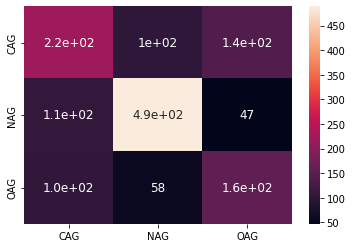

In [48]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 